In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import itertools

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import _tstat_generic

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('failure_times.txt', header = None)

In [3]:
df.head()

,0
0,3
1,33
2,146
3,227
4,342


In [4]:
df.columns = ['failure_time']
df.head()

,failure_time
0,3
1,33
2,146
3,227
4,342


In [5]:
df['time_difference'] = df['failure_time'].diff()
df.head()

,failure_time,time_difference
0,3,NaN
1,33,30.0
2,146,113.0
3,227,81.0
4,342,115.0


In [6]:
failure_diff = df['time_difference'][1:]
failure_diff

1        30.0
2       113.0
3        81.0
4       115.0
5         9.0
        ...  
131     648.0
132    5485.0
133    1160.0
134    1864.0
135    4116.0
Name: time_difference, Length: 135, dtype: float64

In [7]:
failure_1 = df['time_difference'][df['time_difference'] <= 500]
failure_2 = df['time_difference'][df['time_difference'] > 500]

In [8]:
df['time_difference'].mean()

656.8814814814815

In [9]:
t_statistic, p_value = sc.stats.ttest_1samp(failure_diff, 500)

In [10]:
t_statistic, p_value

(1.7572536270462775, 0.08115841841560813)

In [11]:
p_value/2

0.040579209207804064

In [12]:
df['time_difference'][df['time_difference'] > 500].shape[0]

49

In [13]:
print("Sign test:", sign_test(failure_diff, mu0=0.5))

Sign test: (64.5, 1.8834358236050096e-35)


In [14]:
n = len(failure_diff.tolist())

In [15]:
sc.stats.binom_test(49, n = n, p = 0.5, alternative = "greater")

0.9995002578123924

In [16]:
print("Sign test:", sign_test(failure_diff, mu0=500))

Sign test: (-18.5, 0.0018377911087715628)


In [17]:
t_statistic, p_value = sc.stats.wilcoxon(failure_diff - 500, alternative = "greater")

In [18]:
t_statistic, p_value

(4091.5, 0.8632079654217537)

In [19]:
def permutation_t_stat_1s(sample, mean):
    t_stat = sum(sample - mean)
    return t_stat

def permutation_null_distr_1s(sample, mean, max_permutations = None):
    centered_sample = sample - mean
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [permutation_t_stat_1s(centered_sample * np.array(signs), 0) for signs in signs_array]
    return distr

def permutation_test_1s(sample, mean, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1s(sample, mean)
    
    null_distr = permutation_null_distr_1s(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
        
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [20]:
np.random.seed(0)

In [21]:
permutation_test_1s(failure_diff, 500, max_permutations = 10000, alternative = "greater")

{'t': 21179.0, 'p': 0.0366}

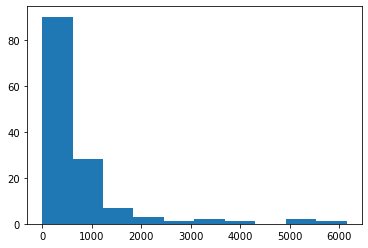

In [22]:
pylab.hist(failure_diff);

In [23]:
failure_diff.mean()

656.8814814814815

In [24]:
failure_diff.median()

290.0

In [25]:
df1 = pd.read_csv('Verizon.txt', sep = '\t')

In [26]:
df1.head()

,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


In [27]:
time_ilec = df1['Time'][df1['Group'] == 'ILEC']
time_clec = df1['Time'][df1['Group'] == 'CLEC']

In [28]:
mean_diff = time_ilec.mean() - time_clec.mean()

In [29]:
mean_diff

-8.097519857859512

In [30]:
statistic, p_vallue = sign_test(time_clec, mu0 = 8.1)

In [31]:
n = time_clec.shape[0]

In [32]:
n

23

In [33]:
time_clec[time_clec > 8].shape[0]

15

In [34]:
sc.stats.binom_test(15, 23, p = 0.5, alternative = "greater")

0.10501980781555172

In [35]:
1 - 0.06690025329589844

0.9330997467041016

In [36]:
t_statistic, p_value, _= ttest_ind(time_ilec, time_clec, usevar = "unequal" )

In [37]:
p_value/2

0.02987306070737932

In [38]:
ttest_ind(time_clec, time_ilec, alternative = 'larger', usevar = 'unequal')

(1.9833785404229538, 0.02987306070737932, 22.3463548265907)

In [39]:
sc.stats.ranksums(time_clec, time_ilec)

RanksumsResult(statistic=3.3117014566153546, pvalue=0.0009273044664289319)

In [40]:
sc.stats.mannwhitneyu(time_clec, time_ilec, alternative = 'greater')

MannwhitneyuResult(statistic=26820.0, pvalue=0.00045651384433380884)

In [41]:
def permutation_t_stat_2s(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [42]:
np.random.seed(0)
permutation_test_2s(time_clec, time_ilec, max_permutations = 10000, alternative = 'greater')

{'t': 8.097519857859512, 'p': 0.0179}